In [44]:
import re, os, math, pickle, feather
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# Data Load

#### Load in data, any thing involving dates or time should be parsed with the parse_dates=['column name'] argument
#### Make a new directory and save a feather version to speed up load times
#### Testing pickle vs. Feather

In [2]:
# % time df_raw = pd.read_csv('tmp_data/Train.csv', low_memory=False, parse_dates=["saledate"])

# Wall time: 54.6 s

In [3]:
# os.makedirs('tmp_data', exist_ok=True)

In [4]:
# # Save df through pickle
# %time pickle_out = open('df_raw.pickle','wb')
# %time pickle.dump(df_raw, pickle_out)
# %time pickle_out.close

# Wall time: 5.98 s

In [5]:
# # Save df through pickle
# %time pickle_out = open('df_raw.pickle','wb')
# %time pickle.dump(df_raw, pickle_out)
# %time pickle_out.close

# Wall time: 3.54 s

In [6]:
# %time df_raw.to_feather('tmp_data/bulldozers-raw')

# Wall time: 2.65 s

In [7]:
%time df_raw = pd.read_feather('tmp_data/bulldozers-raw')

CPU times: user 1.23 s, sys: 824 ms, total: 2.06 s
Wall time: 3.5 s


#### How many columns are made up of non-numeric values?

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null datetime64[ns]
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                

#### Formatting based on required cost function

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

#### Converting all non-numeric values first to categories, then to category codes and saving both versions

In [10]:
def non_numeric_to_cat(dataframe):
    '''Selects all non numeric columns and turns them into categories'''
    non_numeric = dataframe.select_dtypes(exclude=['int','float','datetime']).columns
    dataframe[non_numeric] = dataframe[non_numeric].apply(lambda x: x.astype('category'))
    return dataframe
    
def non_numeric_convert(dataframe):
    '''Selects all non numeric columns and turns them into categorical codes'''
    interp_data = non_numeric_to_cat(dataframe)
    cat_cols = interp_data.select_dtypes(['category']).columns
    model_data = interp_data.copy()
    model_data[cat_cols] = interp_data[cat_cols].apply(lambda x: x.cat.codes)
    model_data = model_data.fillna(model_data.median())

    return interp_data, model_data

In [11]:
# interp_data, model_data = non_numeric_convert(df_raw)

In [12]:
# interp_data.to_feather('tmp_data/bulldozers-interp')
# model_data.to_feather('tmp_data/bulldozers-model')

In [13]:
interp_data = pd.read_feather('tmp_data/bulldozers-interp')
model_data = pd.read_feather('tmp_data/bulldozers-model')

In [14]:
interp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null category
fiModelDesc                 401125 non-null category
fiBaseModel                 401125 non-null category
fiSecondaryDesc             263934 non-null category
fiModelSeries               56908 non-null category
fiModelDescriptor           71919 non-null category
ProductSize                 190350 non-null category
fiProductClassDesc          401125 non-null category
state                       401125 non-null category
ProductGr

In [15]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null float64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                401125 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    401125 non-null float64
UsageBand                   401125 non-null int8
fiModelDesc                 401125 non-null int16
fiBaseModel                 401125 non-null int16
fiSecondaryDesc             401125 non-null int16
fiModelSeries               401125 non-null int8
fiModelDescriptor           401125 non-null int16
ProductSize                 401125 non-null int8
fiProductClassDesc          401125 non-null int8
state                       401125 non-null int8
ProductGroup                401125 non

#### If there is a large amount of columns, you'll get an ellipsis, display.max_columns will prevent this and show all

In [16]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [17]:
display_all(model_data.tail(3))

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
401122,6333338,9.350102,1887659,21439,149,1.0,2005,0.0,-1,656,206,105,62,-1,4,16,19,3,3,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,-1,-1,-1,-1,-1,2,-1,-1,-1,1,18,28,2,1,0,-1,-1,-1,-1,-1,2011,11,44,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,0.0,-1,482,158,105,-1,-1,4,12,8,3,3,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,11,-1,-1,-1,-1,-1,2,-1,-1,-1,1,18,28,2,1,0,-1,-1,-1,-1,-1,2011,10,43,25,1,298,False,False,False,False,False,False,1319500800
401124,6333342,8.955448,1926965,21435,149,2.0,2005,0.0,-1,482,158,105,-1,-1,4,12,8,3,3,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,11,-1,-1,-1,-1,-1,2,-1,-1,-1,1,18,28,2,1,0,-1,-1,-1,-1,-1,2011,10,43,25,1,298,False,False,False,False,False,False,1319500800


In [18]:
display_all(interp_data.tail(3))

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,11,44,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,10,43,25,1,298,False,False,False,False,False,False,1319500800
401124,6333342,8.955448,1926965,21435,149,2.0,2005,NaN,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2011,10,43,25,1,298,False,False,False,False,False,False,1319500800


#### Add datepart is a feature engineering function that will check for things like end of month or year, etc.

In [19]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):   
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [20]:
# add_datepart(interp_data, 'saledate')
# add_datepart(model_data, 'saledate')

In [21]:
display_all(model_data.tail(3))

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
401122,6333338,9.350102,1887659,21439,149,1.0,2005,0.0,-1,656,206,105,62,-1,4,16,19,3,3,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,-1,-1,-1,-1,-1,2,-1,-1,-1,1,18,28,2,1,0,-1,-1,-1,-1,-1,2011,11,44,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,0.0,-1,482,158,105,-1,-1,4,12,8,3,3,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,11,-1,-1,-1,-1,-1,2,-1,-1,-1,1,18,28,2,1,0,-1,-1,-1,-1,-1,2011,10,43,25,1,298,False,False,False,False,False,False,1319500800
401124,6333342,8.955448,1926965,21435,149,2.0,2005,0.0,-1,482,158,105,-1,-1,4,12,8,3,3,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,11,-1,-1,-1,-1,-1,2,-1,-1,-1,1,18,28,2,1,0,-1,-1,-1,-1,-1,2011,10,43,25,1,298,False,False,False,False,False,False,1319500800


### Separating dependent and independent values

In [22]:
X,y = model_data.drop('SalePrice',axis=1), model_data['SalePrice']

### We now have data we can feed into a model!

In [23]:
# model = RandomForestRegressor(n_jobs=-1)
# %time model.fit(X,y)
# model.score(X,y)

### Train / Test Split
#### Since this is time sensitive, we will make our validation set the most recent rows

In [24]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(X)-n_valid
raw_train, raw_valid = split_vals(interp_data, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((389125, 64), (389125,), (12000, 64), (12000,))

In [25]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    train_err = rmse(m.predict(X_train), y_train)
    train_score = m.score(X_train, y_train)
    valid_err = rmse(m.predict(X_valid), y_valid)
    valid_score =  m.score(X_valid, y_valid)
    print('Train RMSE: {}, Train Accuracy: {}'.format(train_err,train_score))
    print('Validation RMSE: {}, Validation Accuracy: {}'.format(valid_err,valid_score))
    if hasattr(m, 'oob_score_'):
        print('OOB Score: {}'.format(m.oob_score_))

In [26]:
# m = RandomForestRegressor(n_jobs=-1)
# %time m.fit(X_train, y_train)
# print_score(m)

## Taking Subsamples to reduce calc time

In [27]:
def df_subsample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [28]:
model_subsample = df_subsample(model_data,70000)
X,y = model_subsample.drop('SalePrice',axis=1), model_subsample['SalePrice']
X_train, X_valid = split_vals(X, 60000)
y_train, y_valid = split_vals(y, 60000)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((60000, 64), (60000,), (10000, 64), (10000,))

In [29]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 24.3 s, sys: 291 ms, total: 24.6 s
Wall time: 8.14 s
Train RMSE: 0.133450576415984, Train Accuracy: 0.9622612176325654
Validation RMSE: 0.29267737891076795, Validation Accuracy: 0.8372159922208703
OOB Score: 0.8820850337278071


## Feature Importance

In [30]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [31]:
fi = rf_feat_importance(m,X)
fi[:10]

,cols,imp
5,YearMade,0.182663
13,ProductSize,0.113811
14,fiProductClassDesc,0.074738
37,Coupler_System,0.066454
39,Hydraulics_Flow,0.056792
2,ModelID,0.052840
63,saleElapsed,0.050729
38,Grouser_Tracks,0.044318
10,fiSecondaryDesc,0.042853
8,fiModelDesc,0.036783


In [32]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

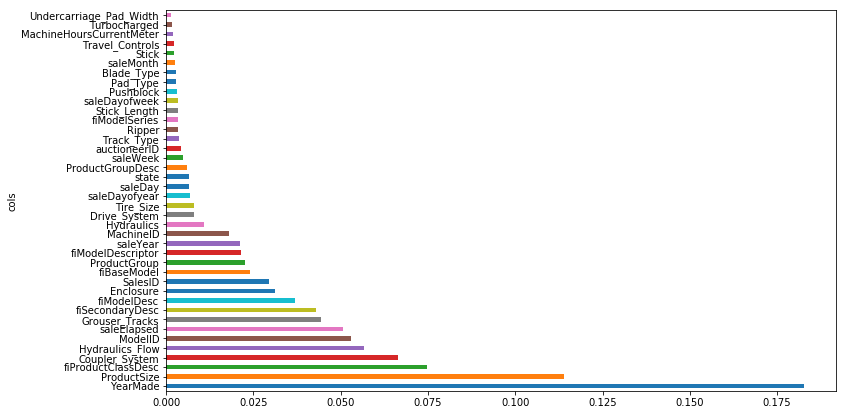

In [39]:
plot_fi(fi[:40]);

## Removing features with little predictive power

In [34]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [35]:
df_keep = X[to_keep].copy()
X_train, X_valid = split_vals(df_keep, 60000)

### Validation Accuracy is the same or better

In [36]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train RMSE: 0.13789510278603392, Train Accuracy: 0.9597056029569664
Validation RMSE: 0.29331429416525584, Validation Accuracy: 0.8365067305055996
OOB Score: 0.8812310777928722


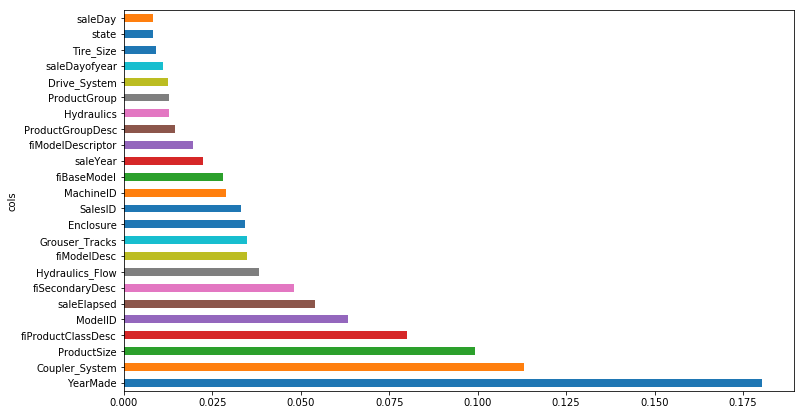

In [37]:
fi2 = rf_feat_importance(m, df_keep)
plot_fi(fi2);

## Removing Redundant Features

In [42]:
import scipy
from scipy.cluster import hierarchy as hc


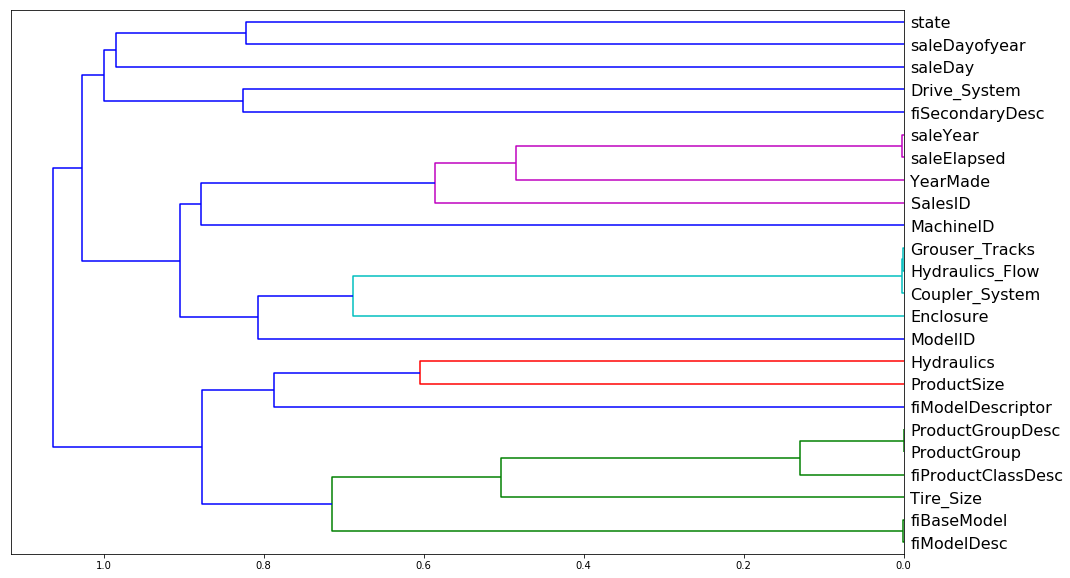

In [45]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [54]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, 60000)
    m.fit(x, y_train)
    return m.oob_score_

In [55]:
get_oob(df_keep)

0.8778692185888122

In [56]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.876776259944795
saleElapsed 0.8751145202566928
fiModelDesc 0.8763896551781086
fiBaseModel 0.8770344001824674
Grouser_Tracks 0.8782715108724605
Coupler_System 0.8785908552406547


In [57]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8772603851213454

In [38]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):   
"""add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)



def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    #################################################
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    #################################################
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.


    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> numericalize(df, df['col2'], 'col3', None)

       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

IndentationError: expected an indented block (<ipython-input-38-185f7e79e7d1>, line 31)